# Preliminary

* By $\mathbb{M}_n(\mathbb{R})$ we denote all real valued square matrices of $n\times n$ size.
* By $\mathbb{M}_n^+(\mathbb{R})$ we denote all positive real valued square matrices of $n\times n$ size.
* By $\mathbb{M}_n^{sa}(\mathbb{R}$ we denote all hermitian (self-adjoint) real valued square matrices of $n\times n$ size.

For a matrix $X\in\mathbb{M}_n^+(\mathbb{R})$ we denote $\Delta(X) = \frac{\sup\sigma(X)-\inf\sigma(X)}{\sup\sigma(X)+\inf\sigma(X)}$ and call $\Delta$ the Michelson contract.

# General Methods used for Monte-Carlo simulations

In [1]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

**generate_alphas** generates spherical coordinated of a point on sphere $\mathbb{S}_{n}$.

In [2]:
def generate_alphas(n: int):
    if n>0:
        alphas = [2*np.pi*random.random()]
        for i in range(1,n): 
            alphas.append(-np.pi/2+np.pi*random.random())
        return alphas
    else:
        return None

**generate_eigenvalues** generates $n$ real values from the interval $[-1,1]$. If **positive** is **True**, then the generated eigenvalues are in the interval $[0,1]$, if **normed** is **True**, then one of the eigenvalues is necesseraly either $1$ or $-1$.

In [3]:
def generate_eigenvalues(n: int, positive: bool = False, normed: bool = True):
    if normed:
        eigenvalues = [1] # here we assume that norm of hermitian operator is just 1
    else:
        eigenvalues = [random.random()]
    antinorm = random.random()*eigenvalues[0]
    for i in range(1,n-1):
        if positive:
            eigenvalues.append(antinorm+(eigenvalues[0]-antinorm)*random.random())
        else:
            sign = 2*(random.random()>0.5)-1
            eigenvalues.append(sign*(antinorm+(eigenvalues[0]-antinorm)*random.random()))
    if positive:
        eigenvalues.append(antinorm)
    else:
        sign = 2*(random.random()>0.5)-1
        antinorm *= sign
        eigenvalues.append(antinorm)
    return eigenvalues

**generate_vector** takes the array of angles generated by **generate_alphas**, so it embeds the point on a sphere into $n$-dimentional Euclidean space.

In [4]:
def generate_vector(alpha_array: np.array):
    vector = []
    current = 1
    for alpha in alpha_array[::-1]:
        vector.append(current*np.sin(alpha))
        current = current*np.cos(alpha)
    vector.append(current)
    return np.array(vector[::-1])

**call_standard_basis** generates the basis $e_1 = (1,0,0,\dots,0)$, $e_2 = (0,1,0,\dots,0)$, $e_3=(0,0,1,\dots,0)$,$\dots$, $e_n = (0,0,0,\dots,1)$. for an input $n$.

In [5]:
def call_standard_basis(n: int):
    basis = []
    for i in range(n):
        vector = np.array(np.zeros(n))
        vector[i] = 1 
        basis.append(vector)
    return basis

**generate_orthonormal_basis** applies the Gram–Schmidt process to $n$ randomly generated vectors. Almost surely the vectors are lineary independent, still if the latter vector has the vanishing orthogonal part, then we regenerate the latter vector.

In [6]:
def generate_orthonormal_basis(n: int, epsilon: float = 0.0001):
    basis = [generate_vector(generate_alphas(n-1))]
    k = 1
    while k < n:
        random_alphas = generate_alphas(n-1)
        new_vector = generate_vector(random_alphas)
        for vec in basis:
            if np.sqrt(np.dot(new_vector,new_vector)) > 0.001:
                new_vector /= np.sqrt(np.dot(new_vector,new_vector))
                new_vector -= vec*np.dot(vec,new_vector)
                if np.sqrt(np.dot(new_vector,new_vector)) > 0.001:
                    new_vector /= np.sqrt(np.dot(new_vector,new_vector))
            else: 
                new_vector = 0 * new_vector
        if np.dot(new_vector,new_vector) > epsilon:
            basis.append(new_vector)
            k += 1
        if k == n:
            break
    return basis

**generate_unitray_matrix** generates an orthogonal matrix.

In [7]:
def generate_unitray_matrix(n: int):
    alpha_array = generate_alphas(n-1)
    basis = generate_orthonormal_basis(n)
    array = np.zeros((n,n))
    for i in range(n):
        array[i,:] = basis[i]
    return array

**generate_hermitian_matrix** generates a hermitian matrix by the following procedure:
1. We take the eigenvalues of the matrix as an input;
2. We generate standard basis;
3. We generate another random orthonormal basis;
4. Then we construct a one-vector projection to the orthonormal basis element as the $p_k=\langle \cdot, f_k\rangle f_k$. The matrix $(m_{ij})$ for this projection is computed as $(p_k)_{ij}=\langle e_i, f_k\rangle \langle f_k, e_j\rangle$;
5. We form the matrix by the spectral theorem $A = \sum_{k=0}^{n} \lambda_k p_k$ and $|A| = \sum_{k=0}^{n} |\lambda_k| p_k$;
6. We return $A$, $|A|$, $\max\sigma(|A|)$, $\min\sigma(|A|)$ and $\Delta(|A|)$.

In [8]:
def generate_hermitian_matrix(eigenvalues: np.array):
    standard_basis = call_standard_basis(len(eigenvalues))
    matrix = np.zeros((len(eigenvalues),len(eigenvalues)))
    matrixabs = np.zeros((len(eigenvalues),len(eigenvalues)))
    basis = generate_orthonormal_basis(len(eigenvalues))
    for eigenvalue, vec in zip(eigenvalues, basis):
        projection = np.zeros((len(eigenvalues),len(eigenvalues)))
        for i in range(len(standard_basis)):
            for j in range(len(standard_basis)):
                projection[i,j] = np.dot(standard_basis[i], np.dot(standard_basis[j], vec)*vec)/np.dot(vec,vec)
        matrix += eigenvalue*projection
        matrixabs += np.abs(eigenvalue)*projection
    norm = np.max(np.abs(eigenvalues))
    antinorm = np.min(np.abs(eigenvalues))
    absdelta = (norm-antinorm)/(norm+antinorm)
    return matrix, matrixabs, norm, antinorm, absdelta

**matrix_abs** of a square matrix $A$ is calculated as the following:
1. We calculate SVD of the $A$ matrix, so $A = U\times D\times V$ with $D$ being diagonal
2. We know that $|A|^2=A^tA = V^t D^t U^t U D V$, which lead us to the $|A|^2=V^t(D^tD)V$ with $D^tD$ being diagonal, thus $D^tD$ is a Jordan decomposition of $|A|^2$.
3. We apply functional calculus and get $|A|=\sqrt{|A|^2}=\sqrt{A^tA}=\sqrt{V^t(D^tD)V}=V^t\sqrt{D^tD}V= V^tDV$.

In [9]:
def matrix_abs(matrix: np.array):
    U,D,V = np.linalg.svd(matrix)
    return np.matmul(V, np.matmul(np.diag(D), np.transpose(V)))


**trace** simply computes canonical matrix trace **trace(matrix)** is simply $\mathrm{tr}(A)$.

In [10]:
def trace(matrix: np.array):
    if matrix.shape[0] == matrix.shape[1]:
        answer = 0
        for i in range(matrix.shape[0]):
            answer += matrix[i,i]
        return answer
    else:
        return None

**find_hermiatian_norm** findes the norm by numerical method of simple iteration.

In [11]:
def find_hermiatian_norm(matrix: np.array):
    if matrix.shape[0] == matrix.shape[1]:
        vec = generate_vector(generate_alphas(matrix.shape[1]-1))
        new_vec = np.array([vec])
        new_vec = np.matmul(new_vec,matrix)
        new_vec /= np.sqrt(np.matmul(new_vec,np.transpose(new_vec)))
        for i in range(100):
            new_vec = np.matmul(new_vec,matrix)
            new_vec /= np.sqrt(np.matmul(new_vec,np.transpose(new_vec)))
        new_vec[np.abs(new_vec)<0.01] = 0
        return np.nanmean(np.matmul(new_vec,matrix)/new_vec)
    else:
        return None

In [12]:
def plot3d(xs,ys,zs,fig,num=1,columns: int = 3,total = 20, xlim = (0,1), ylim = (0,1), zlim=(-1,1)):
    ax = fig.add_subplot(total, 3, num, projection = '3d')
    # Plot a sin curve using the x and y axes.
    ax.scatter(xs, ys, zs, zdir='z')#label='curve in (x, y)')
    # Make legend, set axes limits and labels
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_zlim(zlim[0], zlim[1])
    ax.margins(x=0)
    ax.figure.set_dpi(200)
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    ax.view_init(elev=10., azim=-105, roll=0)
    return ax


In [13]:
def plot2d(xs,ys,fig,num=1,columns: int = 3,total=20, xlim = (0,1), ylim = (0,1)):
    ax = fig.add_subplot(total, columns, num)
    # Plot a sin curve using the x and y axes.
    ax.scatter(xs, ys)#label='curve in (x, y)')
    # Make legend, set axes limits and labels
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    return ax


number of dots for Monte-Carlo simulation.

In [14]:
iterations = 1000000

# 1. Gardner's inequality inspired simulation ($|\mathrm{Tr}(XY)|-\mathrm{Tr}(X|Y|)$)

Gardner [1] showed that the following inequality characterizes traces in the class of semi-finite weights on von Neumann algebras: $|\varphi(X)|\leq \varphi(|X|).$

If $\varphi$ is a traceable functional on the $C^*$-algebra $\mathcal{A}$, then the Gardner exponent shows the result for all elements of $X\in\mathcal{A}$ and, conversely, if for all $ X\in \mathcal{A}$ is a Gardner quality indicator and $\varphi$ is a positive functional, this functional is traceable.

Let $\mathcal{M}$ be a von Neumann algebra, the normal strongly semifinite weight $\varphi$ ensures that for any $\varphi$-finite projects $P\in\mathcal{M}$, the Gardner equivalent ( $|\varphi(X)|\leq \varphi(|X|)$) result for all $X=PX_0P$, where $X_0\in \mathcal{M}$, then the weight is a trace.

[1] Gardner L.T. An inequality сharaсterizes the traсe -- Canad. J. Math. -- V. 31, I. 6. -- P. 1322--1328 -- 1979.


In [15]:
def experiment(dimention = 2):
    array1,absarray1,norm1,antinorm1,absdelta1 = generate_hermitian_matrix(generate_eigenvalues(dimention,True, True))
    array2,absarray2,norm2,antinorm2,absdelta2 = generate_hermitian_matrix(generate_eigenvalues(dimention,True, True))
    U = generate_unitray_matrix(dimention)
    component1 = (norm1-antinorm1)/(norm1+antinorm1)
    component2 = (norm2-antinorm2)/(norm2+antinorm2)
    # |Tr(AU|X|)| - Tr(A|X|)  
    component3 = abs(trace(np.matmul(array1,np.matmul(U,absarray2)))) - trace(np.matmul(array1, absarray2))
    return array1, array2, component1, component2, component3

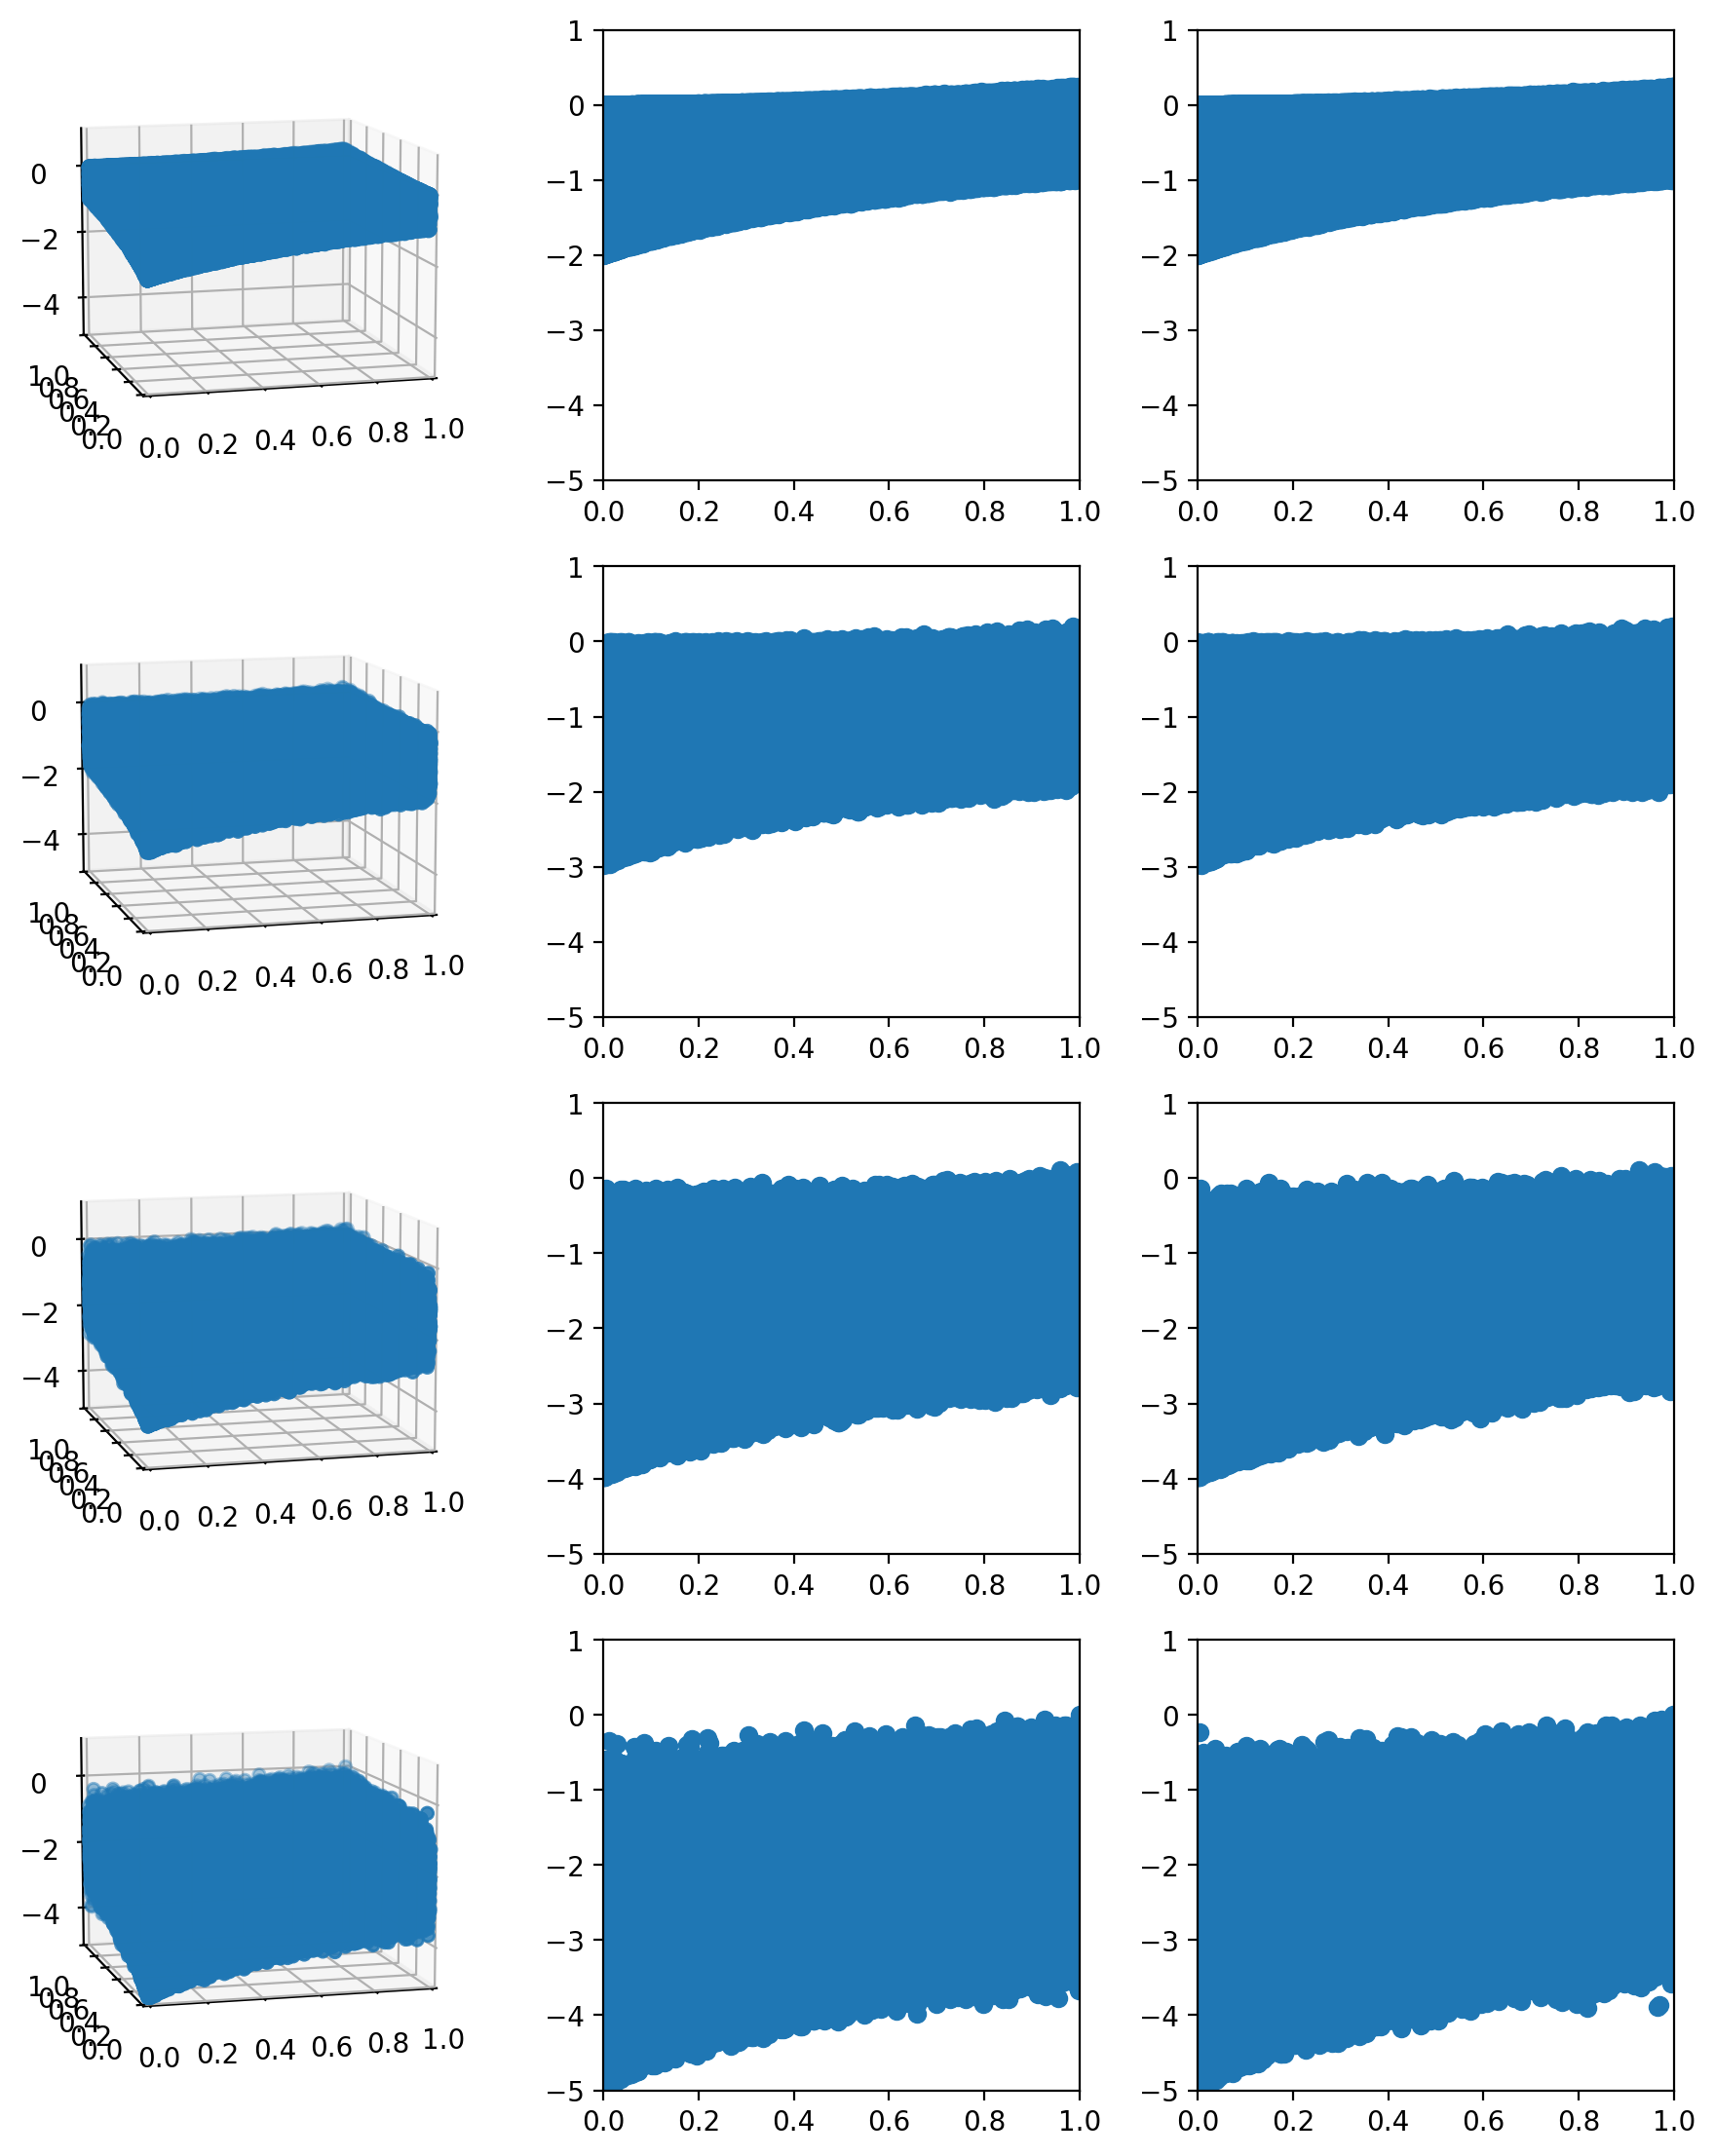

In [16]:
fig = plt.figure(figsize=(9, 55), tight_layout=True)
counter = 1
array1s, array2s, xs, ys, zs = dict(),dict(),dict(),dict(),dict()
for k, dimentions in enumerate([2,3,4,5]):
    array1s[k], array2s[k], xs[k],ys[k],zs[k] = [],[],[],[],[]
    for i in range(iterations):
        array1, array2, x,y,z = experiment(dimentions)
        array1s[k].append(array1)
        array2s[k].append(array2)
        xs[k].append(x)
        ys[k].append(y)
        zs[k].append(z)
    plot3d(xs[k],ys[k],zs[k], fig, counter, xlim = (0,1), ylim = (0,1), zlim = (-5,1))
    counter += 1
    plot2d(xs[k],zs[k], fig, counter, ylim=(-5,1))
    counter += 1
    plot2d(ys[k],zs[k], fig, counter, ylim=(-5,1))
    counter += 1
for k, dimentions in enumerate([2,3,4,5]):
    xs[k],ys[k],zs[k] = np.array(xs[k]),np.array(ys[k]),np.array(zs[k])
plt.show()

The scatterplots above are the modeled values with $x=\Delta(X)$, $y=\Delta(|Y|)$, with $X\in\mathbb{M}^+_n(\mathbb{R}), $\|X\|=1$, Y\in \mathbb{M}_n(\mathbb{R})$, $\|Y\|=1$ and $z=|\mathrm{Tr}(XY)|-\mathrm{Tr}(X|Y|)$. The lefter column is plot of 3D scatterplot, the middle column is plot of $z$ vs. $x$ and righter column is $z$ vs. $y$.

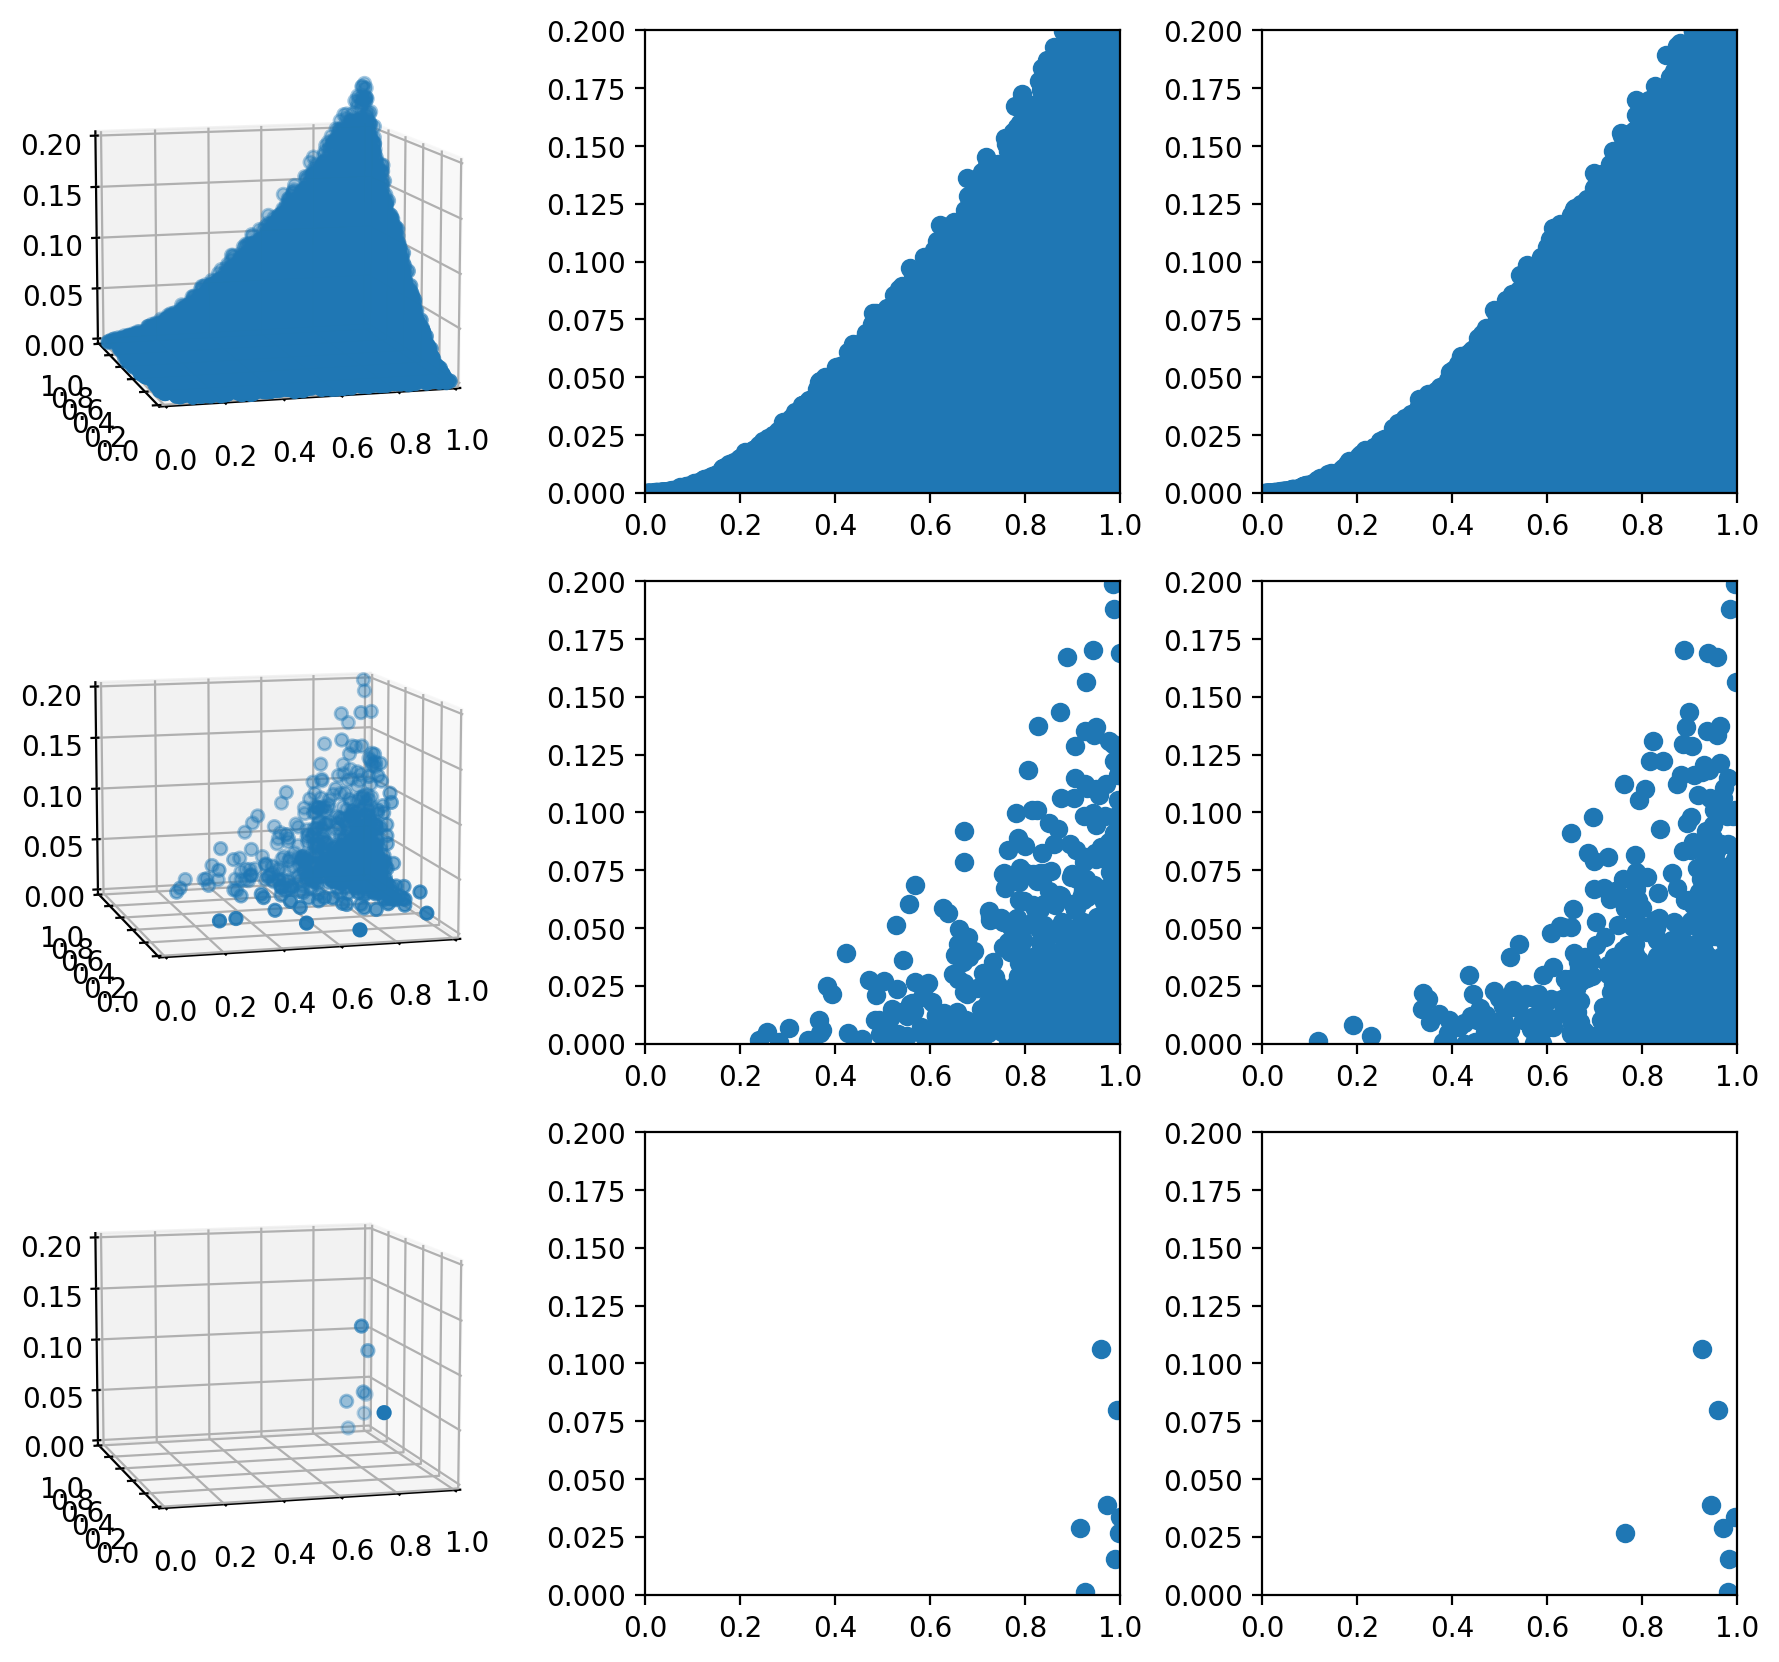

In [17]:
fig = plt.figure(figsize=(9, 55), tight_layout=True)
counter = 1
for k, dimentions in enumerate([2,3,4]):
    locx = xs[k][zs[k]>0]
    locy = ys[k][zs[k]>0]
    locz = zs[k][zs[k]>0]
    plot3d(locx,locy,locz, fig, counter, xlim = (0,1), ylim = (0,1), zlim = (0,0.2))
    counter += 1
    plot2d(locx,locz, fig, counter, ylim=(0,0.2))
    counter += 1
    plot2d(locy,locz, fig, counter, ylim=(0,0.2))
    counter += 1
plt.show()

The scatterplots above are the modeled values with $x=\Delta(|X|)$, $y=\Delta(|Y|)$, with $X\in\mathbb{M}^+_n(\mathbb{R})$, $\|X\|=1$, $Y\in \mathbb{M}_n(\mathbb{R})$, $\|Y\|=1$ and $z=|\mathrm{Tr}(XY)|-\mathrm{Tr}(X|Y|)$. The lefter column is plot of 3D scatterplot, the middle column is plot of $z$ vs. $x$ and righter column is $z$ vs. $y$. We filter only the $z>0$ part.

In [18]:
for k, dimentions in enumerate([2,3,4,5]):
    pd.DataFrame({"X":array1s[k], "Y":array2s[k], "deltaX":xs[k], "deltaY":ys[k], "difference":zs[k]}).to_csv("first_case_"+str(dimentions)+".csv")

# 2. Gardner's inequality inspired simulation ($|\mathrm{Tr}(XY)|-\mathrm{Tr}(|X||Y|)$)

In [19]:
def experiment(dimention = 2):
    array1,absarray1,norm1,antinorm1,absdelta1 = generate_hermitian_matrix(generate_eigenvalues(dimention,True, True))
    array2,absarray2,norm2,antinorm2,absdelta2 = generate_hermitian_matrix(generate_eigenvalues(dimention,True, True))
    U = generate_unitray_matrix(dimention)
    V = generate_unitray_matrix(dimention)
    array1 = np.matmul(U,array1)
    array2 = np.matmul(V,array2)
    component1 = (norm1-antinorm1)/(norm1+antinorm1)
    component2 = (norm2-antinorm2)/(norm2+antinorm2)
    # Tr(|AX|) - Tr(|A||X|)  
    component3 =  trace(matrix_abs(np.matmul(array1,array2))) - trace(np.matmul(absarray1, absarray2))
    return array1, array2, component1, component2, component3

In [20]:
counter = 1
array1s, array2s, xs, ys, zs = dict(),dict(),dict(),dict(),dict()
for k, dimentions in enumerate([2,3,4,5]):
    array1s[k], array2s[k], xs[k],ys[k],zs[k] = [],[],[],[],[]
    for i in range(iterations):
        array1, array2, x,y,z = experiment(dimentions)
        array1s[k].append(array1)
        array2s[k].append(array2)
        xs[k].append(x)
        ys[k].append(y)
        zs[k].append(z)
for k, dimentions in enumerate([2,3,4,5]):
    xs[k],ys[k],zs[k] = np.array(xs[k]),np.array(ys[k]),np.array(zs[k])
plt.show()

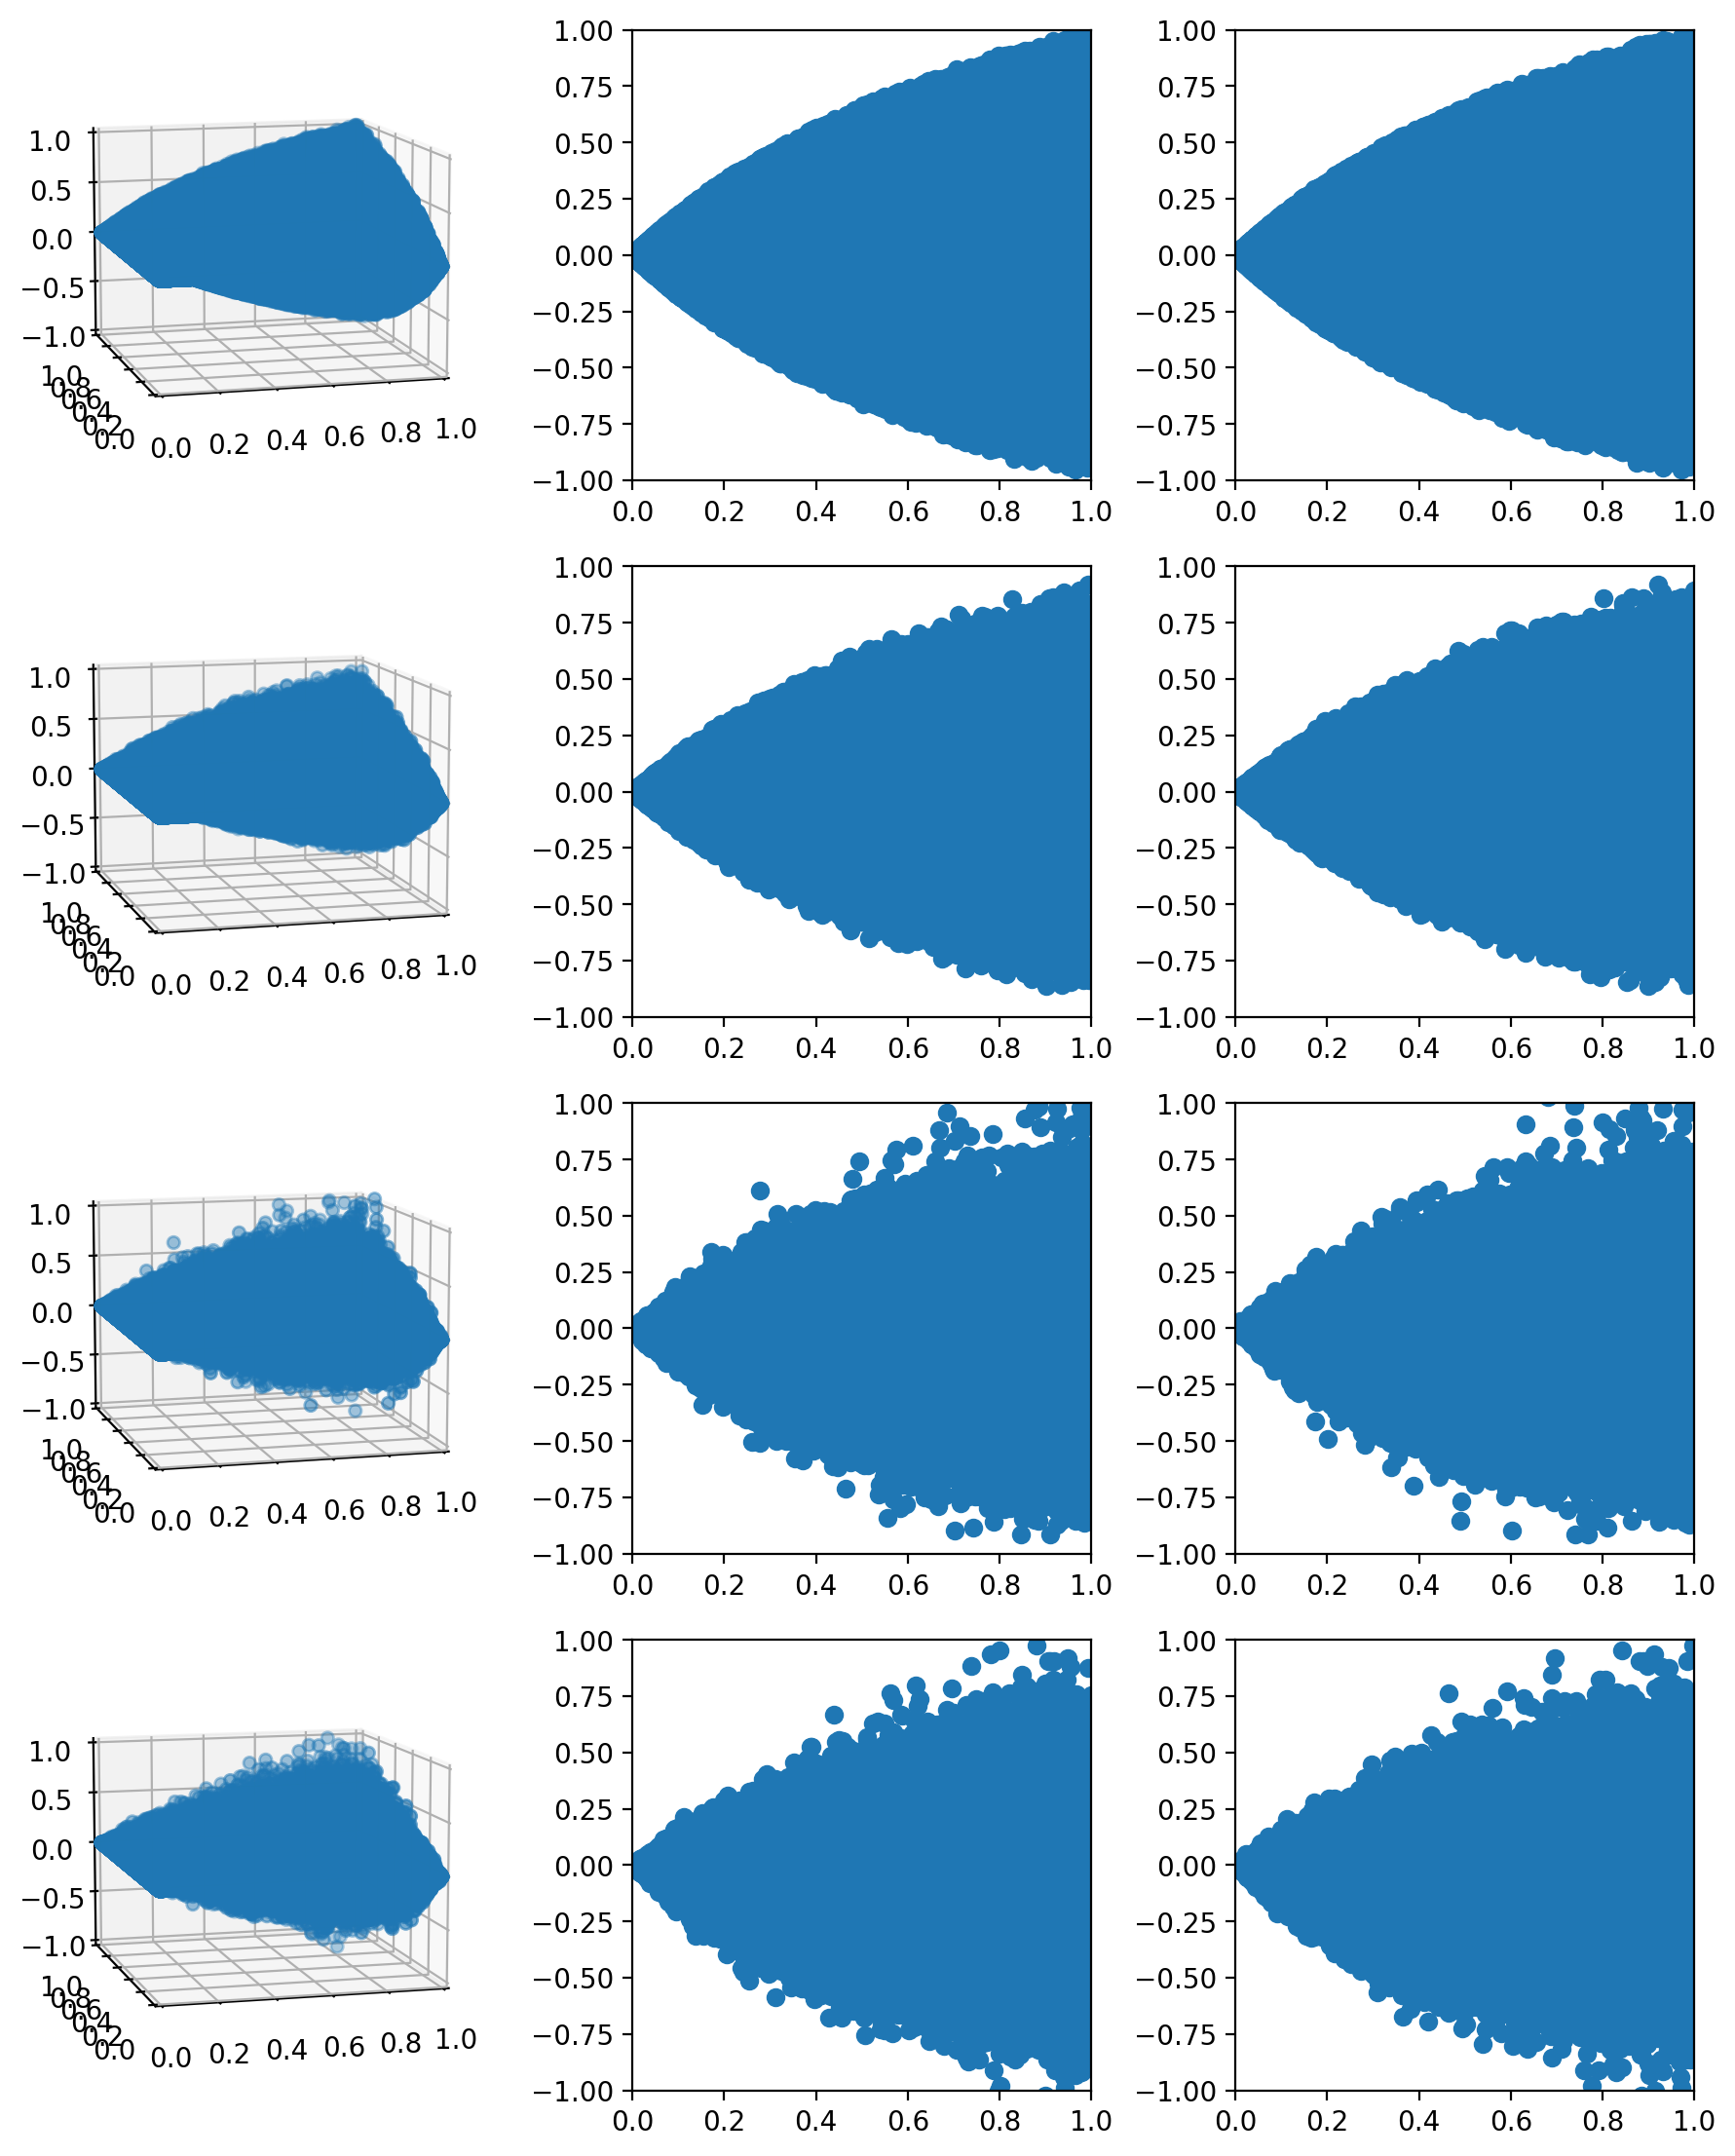

In [21]:
fig = plt.figure(figsize=(9, 55), tight_layout=True)
counter = 1
for k, dimentions in enumerate([2,3,4,5]):
    locx = xs[k]
    locy = ys[k]
    locz = zs[k]
    plot3d(locx,locy,locz, fig, counter, xlim = (0,1), ylim = (0,1), zlim = (-1,1))
    counter += 1
    plot2d(locx,locz, fig, counter, ylim=(-1,1))
    counter += 1
    plot2d(locy,locz, fig, counter, ylim=(-1,1))
    counter += 1
plt.show()

The scatterplots above are the modeled values with $x=\Delta(|X|)$, $y=\Delta(|Y|)$, with $X,Y\in\mathbb{M}_n(\mathbb{R})$,$\|X\|=\|Y\|=1$ and $z=|\mathrm{Tr}(XY)|-\mathrm{Tr}(|X||Y|)$. The lefter column is plot of 3D scatterplot, the middle column is plot of $z$ vs. $x$ and righter column is $z$ vs. $y$.

In [22]:
for k, dimentions in enumerate([2,3,4,5]):
    pd.DataFrame({"X":array1s[k], "Y":array2s[k], "deltaX":xs[k], "deltaY":ys[k], "difference":zs[k]}).to_csv("second_case_"+str(dimentions)+".csv")

# 3 $L_1$-equality violation

From [2] we now that if $A\in \mathbb{M}^+_n(\mathbb{R})$ and $\mathrm{Tr}(|AXA|) = \mathrm{Tr}(A|X|A)$ for all $X\in\mathbb{M}_n^{sa}(\mathbb{R})$ then $A$ is central.

[2] Novikov A. -- $L_1$-space for a positive operator affiliated with von Neumann algebra -- Positivity -- V.21, I. 1. -- 359-375 -- 2017 

The scatterplots above are the modeled values with $x=\Delta(X)$, $y=\Delta(Y)$, with $X\in\mathbb{M}^+_n(\mathbb{R})$, $\|X\|=1$, $Y\in \mathbb{M}_n(\mathbb{R})$, $\|Y\|=1$ and $z=\mathrm{Tr}(X|Y|X) - |\mathrm{Tr}(|XYX|)|$. The lefter column is plot of 3D scatterplot, the middle column is plot of $z$ vs. $x$ and righter column is $z$ vs. $y$.

In [23]:
def experiment(dimention = 2):
    X,absX,normX,antinormX,absdeltaX = generate_hermitian_matrix(generate_eigenvalues(dimention,False, True))
    Y,absY,normY,antinormY,absdeltaY = generate_hermitian_matrix(generate_eigenvalues(dimention,True, True))
    component1 = (normX-antinormX)/(normX+antinormX)
    component2 = (normY-antinormY)/(normY+antinormY)
    # Tr(Y|X|Y) - Tr(|YXY|)  
    component3 =  trace(np.matmul(np.matmul(Y,absX),Y)) - trace(matrix_abs(np.matmul(Y,np.matmul(X,Y))))
    return X,Y,component1, component2, component3

In [24]:
counter = 1
array1s,array2s,xs, ys, zs = dict(),dict(),dict(),dict(),dict()
for k, dimentions in enumerate([2,3,4,5]):
    array1s[k], array2s[k], xs[k],ys[k],zs[k] = [],[],[],[],[]
    for i in range(iterations):
        array1,array2,x,y,z = experiment(dimentions)
        array1s[k].append(array1)
        array2s[k].append(array2)
        xs[k].append(x)
        ys[k].append(y)
        zs[k].append(z)
for k, dimentions in enumerate([2,3,4,5]):
    xs[k],ys[k],zs[k] = np.array(xs[k]),np.array(ys[k]),np.array(zs[k])
plt.show()

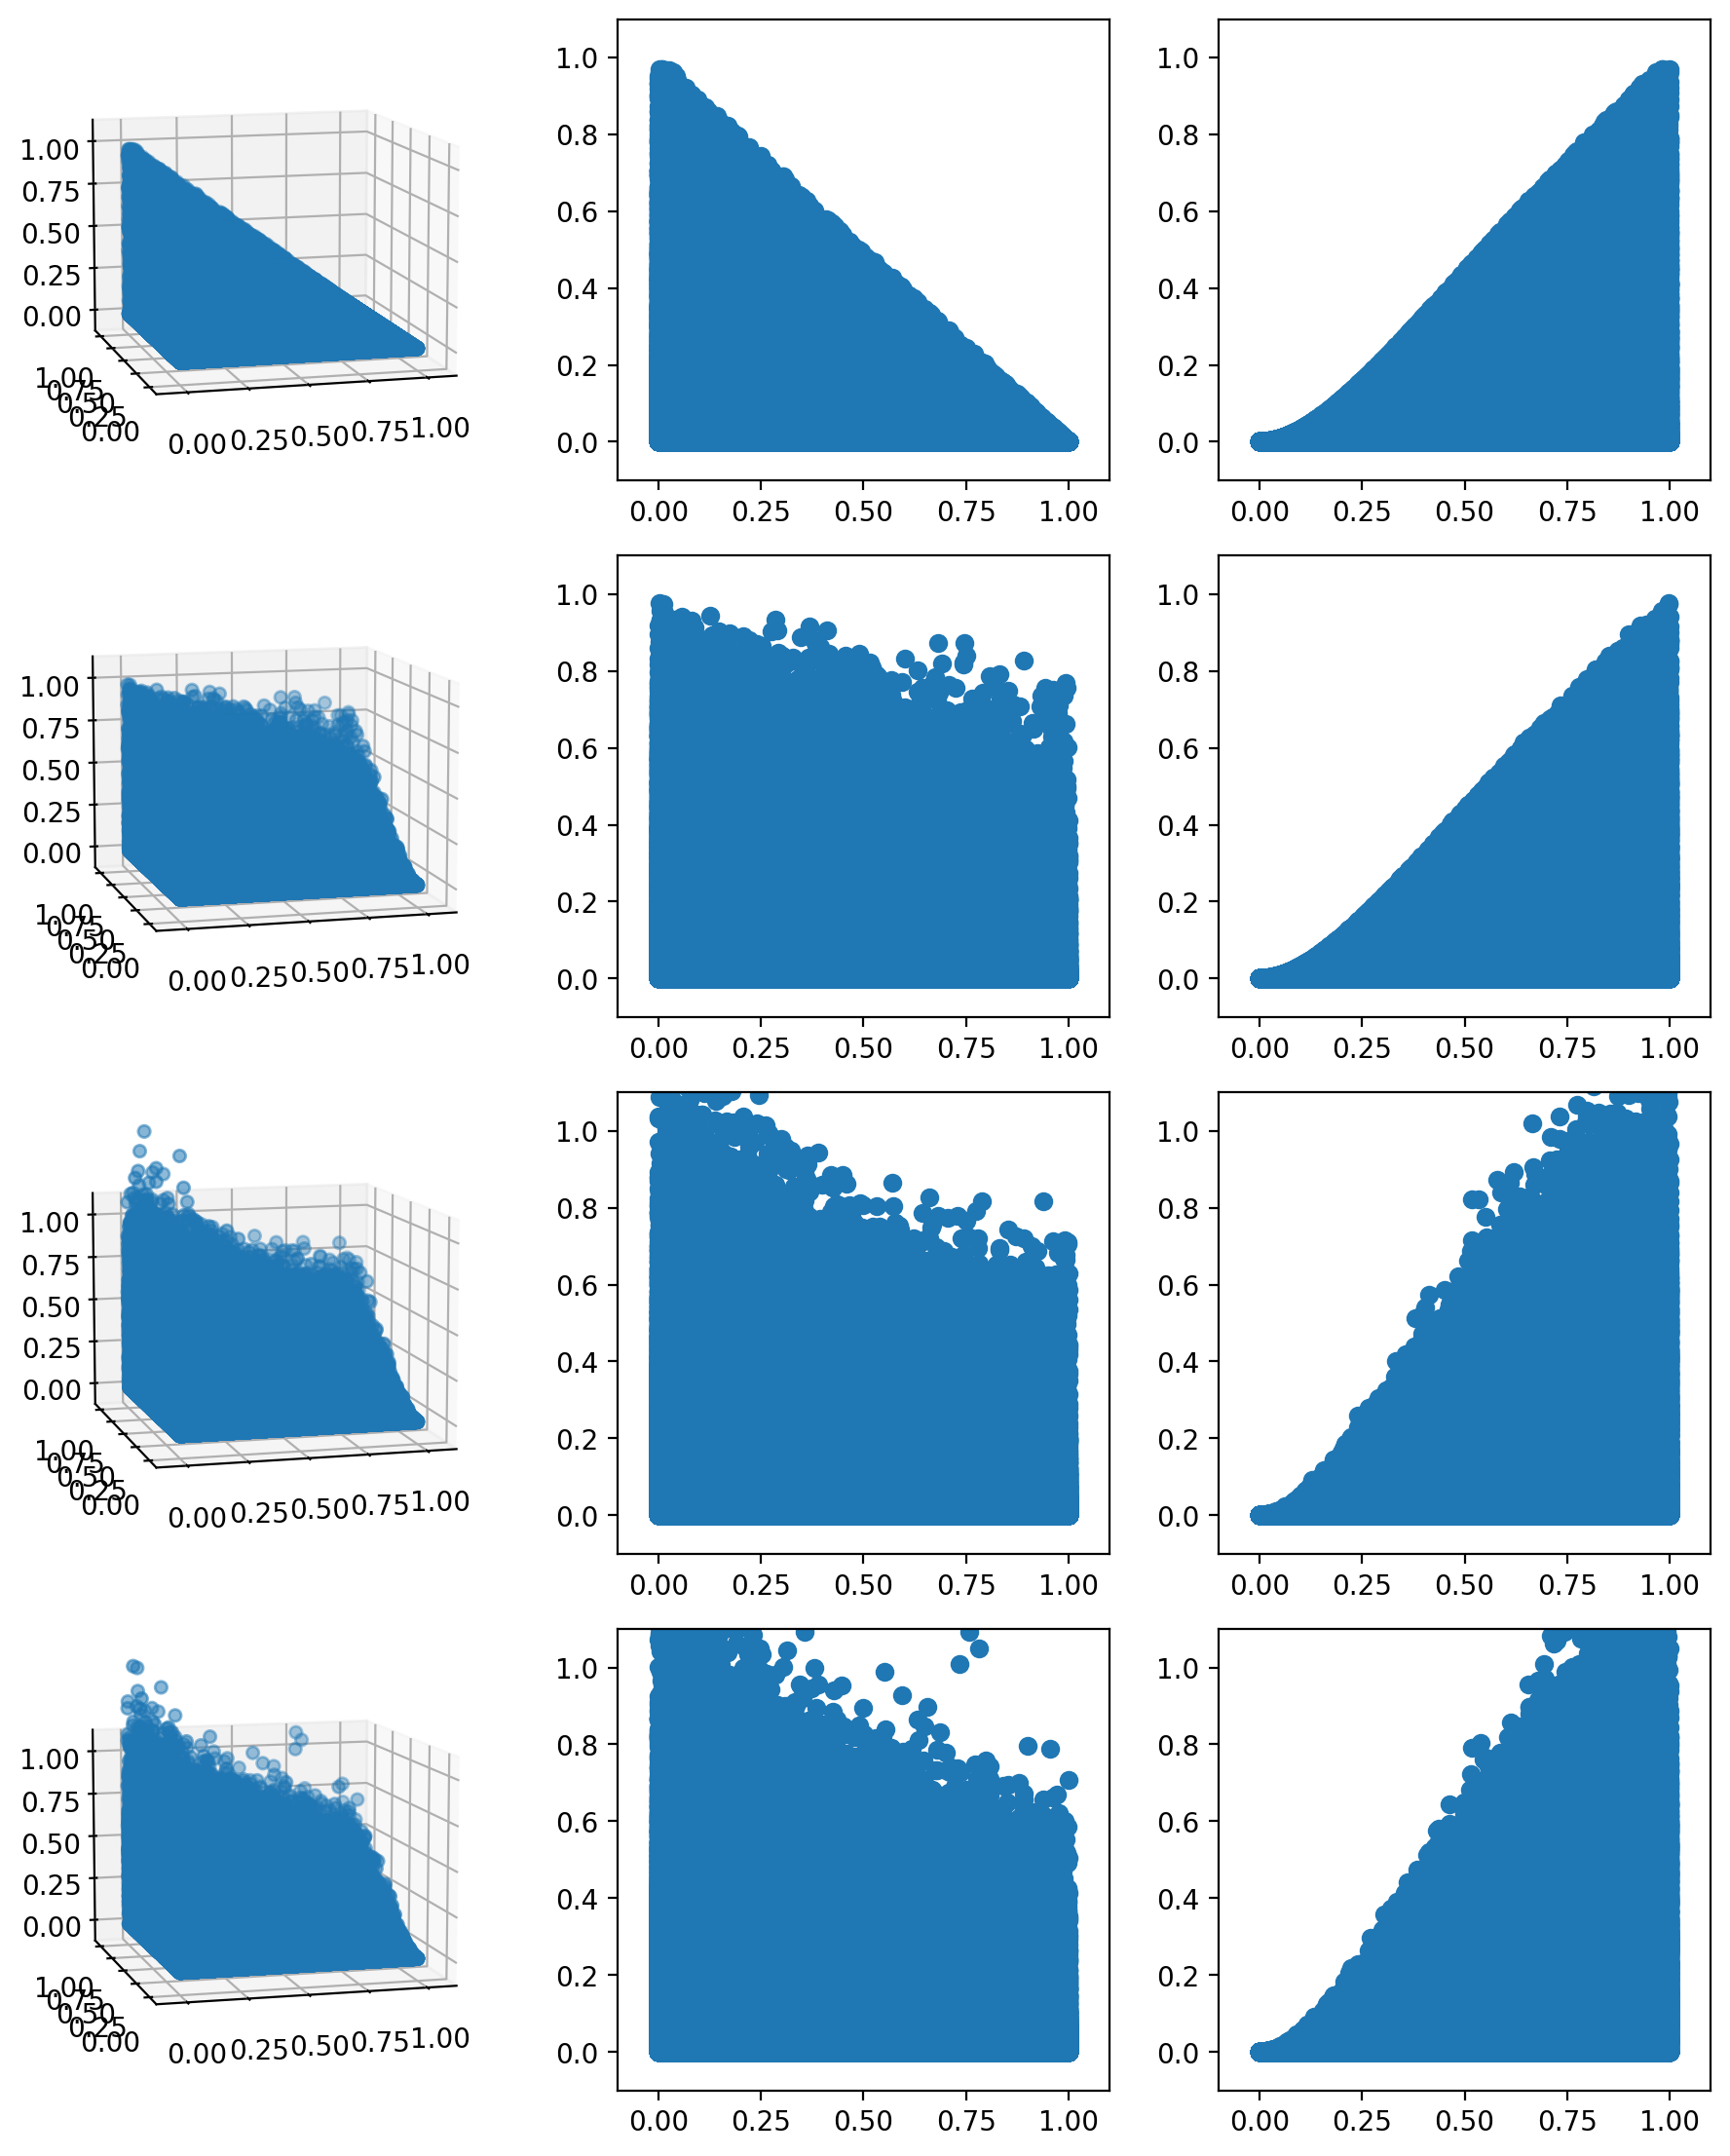

In [25]:
fig = plt.figure(figsize=(9, 55), tight_layout=True)
counter = 1
for k, dimentions in enumerate([2,3,4,5]):
    locx = xs[k]
    locy = ys[k]
    locz = zs[k]
    plot3d(locx,locy,locz, fig, counter, xlim = (-0.1,1.1), ylim = (-0.1,1.1), zlim = (-0.1,1.1))
    counter += 1
    plot2d(locx,locz, fig, counter,  xlim = (-0.1,1.1), ylim=(-0.1,1.1))
    counter += 1
    plot2d(locy,locz, fig, counter,  xlim = (-0.1,1.1), ylim=(-0.1,1.1))
    counter += 1
plt.show()

The scatterplots above are the modeled values with $x=\Delta(|X|)$, $y=\Delta(Y)$, with $X\in\mathbb{M}_n^{sa}(\mathbb{R})$,$\|X\|=1$, $Y\in \mathbb{M}_n^+(\mathbb{R})$, $\|Y\|=1$ and $z=\mathrm{Tr}(Y|X|Y) - |\mathrm{Tr}(|YXY|)|$. The lefter column is plot of 3D scatterplot, the middle column is plot of $z$ vs. $x$ and righter column is $z$ vs. $y$.

In [26]:
for k, dimentions in enumerate([2,3,4,5]):
    pd.DataFrame({"X":array1s[k], "Y":array2s[k], "deltaX":xs[k], "deltaY":ys[k], "difference":zs[k]}).to_csv("third_case_"+str(dimentions)+".csv")

# References

[1] Gardner L.T. An inequality сharaсterizes the traсe -- Canad. J. Math. -- V. 31, I. 6. -- P. 1322--1328 -- 1979.

[2] Novikov A. $L_1$-space for a positive operator affiliated with von Neumann algebra -- Positivity -- V.21, I. 1. -- 359-375 -- 2017